In [1]:
import numpy as np
mutated_data = np.load("/content/MUTATION_DATA_TRAINING_6000.npz", allow_pickle=True)
mutated_test = mutated_data['arr_0'][:1000]
output_test = "MUTATED_DATA_TEST_1000_6000"
np.savez_compressed(output_test, arr_0=np.array(mutated_test))
mutated_val = mutated_data['arr_0'][5000:]
output_val = "MUTATED_DATA_VAL_1000_6000"
np.savez_compressed(output_val, arr_0=np.array(mutated_val))
mutated_train = mutated_data['arr_0'][1000:5000]
output_train = "MUTATED_DATA_TRAIN_5000_6000"
np.savez_compressed(output_train, arr_0=np.array(mutated_train))



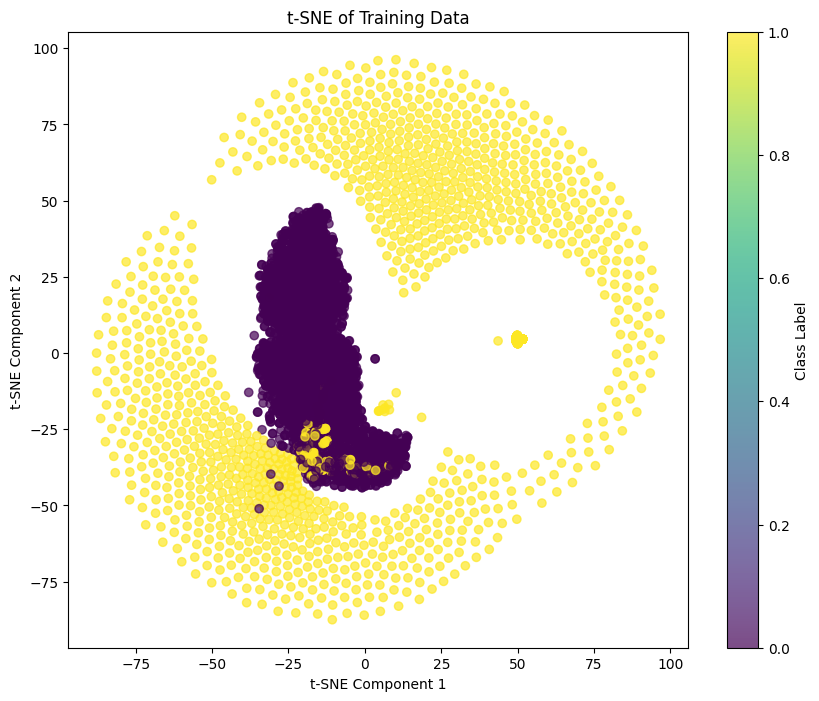

In [157]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras import regularizers
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# Function to load sequences (unchanged)
def load_sequences(data):
    encoded_sequences = None
    for key in data.files:
        temp_sequences = data[key]
        if temp_sequences.ndim == 2:
            num_samples = temp_sequences.shape[0]
            sequence_length = temp_sequences.shape[1] // 4
            temp_sequences = np.expand_dims(temp_sequences, axis=1)
        if temp_sequences.ndim == 3:
            encoded_sequences = temp_sequences
            break
    return encoded_sequences

def load_sequences_with_shape(data):
    encoded_sequences = None
    for key in data.files:
        temp_sequences = data[key]
        if temp_sequences.ndim == 2:  # If 2D, reshape to 3D for LSTM
            temp_sequences = np.expand_dims(temp_sequences, axis=1)  # (samples, 1, features)
        if temp_sequences.ndim == 3:
            encoded_sequences = temp_sequences
            input_shape = input_shape=(encoded_sequences.shape[1], encoded_sequences.shape[2])
            break
    return encoded_sequences, input_shape

# Loading the data (unchanged)
mutated_data = np.load("/content/MUTATION_DATA_TRAINING_TRUE.npz", allow_pickle=True)
nonmutated_data = np.load("/content/AUGMENTED_DATA_TRAINING_6000_TRUE_1.npz", allow_pickle=True)

mutated_sequences, shape = load_sequences_with_shape(mutated_data)
nonmutated_sequences, shape = load_sequences_with_shape(nonmutated_data)

# Further loading of test, validation, and train data (unchanged)
mutated_test_1 = np.load("/content/MUTATED_DATA_TEST_1000_6000_TRUE_1.npz", allow_pickle=True)
mutated_test = load_sequences(mutated_test_1)
mutated_test_label = np.ones(mutated_test.shape[0])
mutated_test, mutated_test_label = shuffle(mutated_test, mutated_test_label, random_state=42)

mutated_val_1 = np.load("/content/MUTATED_DATA_VAL_1000_6000_TRUE_1.npz", allow_pickle=True)
mutated_val = load_sequences(mutated_val_1)
mutated_val_label = np.ones(mutated_val.shape[0])
mutated_val, mutated_val_label = shuffle(mutated_val, mutated_val_label, random_state=42)

mutated_train_1 = np.load("/content/MUTATED_DATA_TRAIN_5000_6000_TRUE_1.npz", allow_pickle=True)
mutated_train = load_sequences(mutated_train_1)
mutated_train_label = np.ones(mutated_train.shape[0])
mutated_train, mutated_train_label = shuffle(mutated_train, mutated_train_label, random_state=42)

nonmutated_test_1 = np.load("/content/AUGMENTED_DATA_TEST_1000_6000_TRUE.npz", allow_pickle=True)
nonmutated_test = load_sequences(nonmutated_test_1)
nonmutated_test_label = np.zeros(nonmutated_test.shape[0])
nonmutated_test, nonmutated_test_label = shuffle(nonmutated_test, nonmutated_test_label, random_state=42)

nonmutated_val_1 = np.load("/content/AUGMENTED_DATA_TEST_VAL_1000_6000_TRUE.npz", allow_pickle=True)
nonmutated_val = load_sequences(nonmutated_val_1)
nonmutated_val_label = np.zeros(nonmutated_val.shape[0])
nonmutated_val, nonmutated_val_label = shuffle(nonmutated_val, nonmutated_val_label, random_state=42)

nonmutated_train_1 = np.load("/content/AUGMENTED_DATA_TRAIN_5000_6000_TRUE.npz", allow_pickle=True)
nonmutated_train = load_sequences(nonmutated_train_1)
nonmutated_train_label = np.zeros(nonmutated_train.shape[0])
nonmutated_train, nonmutated_train_label = shuffle(nonmutated_train, nonmutated_train_label, random_state=42)

# Combine the mutated and nonmutated data for training, validation, and testing (unchanged)
X_val = np.concatenate([mutated_val, nonmutated_val], axis=0)
y_val = np.concatenate([mutated_val_label, nonmutated_val_label], axis=0)
X_val, y_val = shuffle(X_val, y_val, random_state=1)

X_test = np.concatenate([mutated_test, nonmutated_test], axis=0)
y_test = np.concatenate([mutated_test_label, nonmutated_test_label], axis=0)
X_test, y_test = shuffle(X_test, y_test, random_state=1)

X_train = np.concatenate([mutated_train, nonmutated_train], axis=0)
y_train = np.concatenate([mutated_train_label, nonmutated_train_label], axis=0)
X_train, y_train = shuffle(X_train, y_train, random_state=1)

# Now applying PCA to the training, validation, and test data
def apply_tsne(X_train, X_val, X_test, n_components=2):
    # Apply t-SNE to the data
    tsne = TSNE(n_components=n_components, random_state=42)

    # For t-SNE, we typically flatten the data before applying it
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Fit and transform training data
    X_train_tsne = tsne.fit_transform(X_train_flat)

    # Optionally transform validation and test data
    X_val_tsne = tsne.fit_transform(X_val_flat)
    X_test_tsne = tsne.fit_transform(X_test_flat)

    return X_train_tsne, X_val_tsne, X_test_tsne

# Apply t-SNE to training, validation, and test data
X_train_tsne, X_val_tsne, X_test_tsne = apply_tsne(X_train, X_val, X_test)

# Visualizing the t-SNE results (for training data)
plt.figure(figsize=(10, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.colorbar(label='Class Label')  # This will show the color mapping to classes
plt.title("t-SNE of Training Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Print to verify
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.0, 1: 1.0}


In [15]:
import seaborn as sns
flat_control_data = nonmutated_val.flatten()
flat_mutated_data = mutated_val.flatten()

# Plotting histograms for comparison
plt.figure(figsize=(12, 6))

# Plot histogram for control data
plt.subplot(1, 2, 1)
sns.histplot(flat_control_data, bins=50, kde=True, color="blue")
plt.title("Control Data (Non-mutated)")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")

# Plot histogram for mutated data
plt.subplot(1, 2, 2)
sns.histplot(flat_mutated_data, bins=50, kde=True, color="red")
plt.title("Mutated Data")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [160]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow import keras
def rnn_model(input_shape):
    model = Sequential([
        LSTM(32, input_shape = shape, return_sequences=False, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.01))  # Output layer with L2
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0), loss="binary_crossentropy", metrics=["accuracy"])
    return model
def reset_rnn(input_shape):
    # Recreate the model to reset weights
    model = rnn_model(input_shape)
    return model

# Train the model
checkpoint_path = "E:/my_models/6000_3_if_new_best_model.weights.h5"
shape = input_shape=(X_train_tsne.shape[1], 1)
model1 = reset_rnn(shape)

In [154]:

checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, verbose=1)
csv_logger = CSVLogger("training_log_6000_3.csv")

history = model1.fit(X_train_pca, y_train, validation_data=(X_val_pca, y_val),
                    epochs=10, batch_size=16, callbacks=[checkpoint, csv_logger])


# Evaluate the model
y_pred = model1.predict(X_test)
print(y_pred)
y_pred_classes = (y_pred > 0.5).astype("int32")
report = classification_report(y_test, y_pred_classes)
report_df = pd.DataFrame(report).transpose()

# Save the report to a CSV file
report_df.to_csv("6000_new_if_classification_report.csv")
# Evaluate model performance
print(report)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.5f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Test Accuracy
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model1.predict(X_test).flatten()
print("\n🔹 First 10 Predictions vs Actual Values 🔹")
for i in range(10):
    print(f"Sample {i+1}: Actual = {y_test[i]}, Predicted Probability = {predictions[i]:.4f}")

Epoch 1/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6848 - loss: 0.6779
Epoch 1: val_loss improved from inf to 0.69355, saving model to E:/my_models/6000_3_if_new_best_model.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.6852 - loss: 0.6775 - val_accuracy: 0.6720 - val_loss: 0.6936
Epoch 2/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9200 - loss: 0.4348
Epoch 2: val_loss improved from 0.69355 to 0.63530, saving model to E:/my_models/6000_3_if_new_best_model.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9200 - loss: 0.4347 - val_accuracy: 0.6505 - val_loss: 0.6353
Epoch 3/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9474 - loss: 0.3671
Epoch 3: val_loss did not improve from 0.63530
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9474 - loss: 0.3670 - val_accuracy: 0.6140 - val_loss: 0.6785
Epoch 4/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9653 - loss: 0.3168
Epoch 4: val_loss 

ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 52000 and 1 for '{{node sequential_75_1/lstm_176_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_75_1/lstm_176_1/strided_slice_1, sequential_75_1/lstm_176_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [32,52000], [1,128].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(32, 52000), dtype=float32)
  • states=('tf.Tensor(shape=(32, 32), dtype=float32)', 'tf.Tensor(shape=(32, 32), dtype=float32)')
  • training=False

In [159]:
model1.summary()

# Check regularizers applied to each layer:
for layer in model1.layers:
    if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer is not None:
        print(f"Layer {layer.name} has regularizer: {layer.kernel_regularizer}")


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_177 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_139 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_141 (Dense)                    │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_140 (Dropout)                │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_142 (Dense)                    │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,753 (18.57 KB)

 Trainable params: 4,689 (18.32 KB)

 Non-trainable params: 64 (256.00 B)

Layer lstm_177 has regularizer: <keras.src.regularizers.regularizers.L2 object at 0x7f00ed6c2140>
Layer dense_141 has regularizer: <keras.src.regularizers.regularizers.L2 object at 0x7f019246ae00>
Layer dense_142 has regularizer: <keras.src.regularizers.regularizers.L2 object at 0x7f00ed67e980>


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9156 - loss: 0.6236
Test Accuracy: 0.9195
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      1000
         1.0       0.95      0.89      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

ROC-AUC: 0.9335709999999999


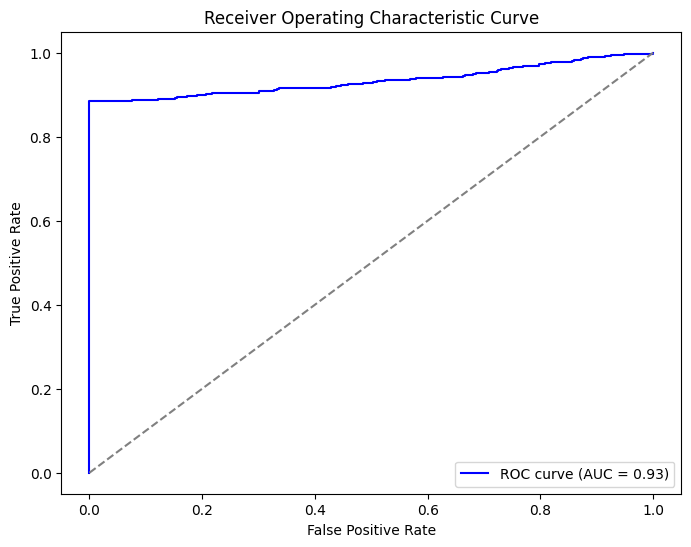

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [86]:
loss, accuracy = model1.evaluate(X_test_pca, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
y_pred = model1.predict(X_test_pca)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Evaluate model performance
print(classification_report(y_test, y_pred_classes))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Test Accuracy
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model1.predict(X_test).flatten()
print("\n🔹 First 10 Predictions vs Actual Values 🔹")
for i in range(10):
    print(f"Sample {i+1}: Actual = {y_test[i]}, Predicted Probability = {predictions[i]:.4f}")

In [ ]:
import shap
explainer = shap.Explainer(model, X_train)
explainer = shap.GradientExplainer(model, X_train_combined[:100])
# Calculate SHAP values for the input data
shap_values = explainer(X_train)






KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values, input_data)

In [ ]:
shap.initjs()  # Initialize JavaScript visualization
shap.force_plot(shap_values[0], input_data[0]

In [ ]:
shap.dependence_plot("feature_name", shap_values, input_data)

In [ ]:
shap.waterfall_plot(shap_values[0])